# Baseline Rhythmic Assessment System

Throughout this notebook we are going to ilustrate the utility of our MAST Rhythmic subset for assessment tasks. This goal will be accomplished by creating a simple rhythmic assessment system which uses the previously calculated onset data to predict quantitative assessments (i.e. grades) for rhythmic performances.

The following requires that you have went through the _PreProcessDataFromMASTDataset.ipynb_ notebook.

Start by importing necessary modules and creating some auxiliar functions able to handle the data previously stored in the pre-processing phase.

In [63]:
import os

DATA_FOLDER = "../data/"

       
### storage handlers ###
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
def get_info(index, performance_type, info_file_format):   
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]
    

audio_file = '53_rhy1_ref187859.wav'
idx = get_audio_index(audio_file, 'reference')

print('Onset bins for %s:' % audio_file, get_info(idx, 'reference', 'MAST Onsets [{}s] [BINS]'))

Onset bins for 53_rhy1_ref187859.wav: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


Now we define two extra functions designed to enrich the feature model: (1) beat difference between performance and reference, and (2) a normalized rhythmic Mean-Squared-Error originally proposed by Percival in http://percival-music.ca/research/masters-percival.pdf. The other distances comprised by the feature set are the [Levenshtein (aka Edit Distance)](https://en.wikipedia.org/wiki/Levenshtein_distance), [Damerau Levenshtein](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance), [Jaro](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance#Jaro_Similarity), [Jaro Winkler](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance), [Hamming](https://en.wikipedia.org/wiki/Hamming_distance), [Yule](https://reference.wolfram.com/language/ref/YuleDissimilarity.html) and [Matching](https://en.wikipedia.org/wiki/Matching_distance).

The third function below is responsible for deriving the targets (dependent variables) from the annotation data. Two targets are considered: a continuous target regarding the mean annotated grade, and a binary target meaning whether or not a performance was accepted. In this scenario a performance is successful if its average grade is greater or equal than 3.

In [64]:
import numpy as np

def beat_difference(v1, v2):
    return abs(v1.count(1) - v2.count(1))

def mean_squared_error_for_rhythm(A_bin, E_bin, Km = 25 , Ks = 0.55):
    '''
    Implementation of a MSE function designed
    for rhythmic assessment purposes. The original
    algorithm is proposed by Percival in
    http://percival-music.ca/research/masters-percival.pdf
    '''
    def closest_value(alist, value):
        min_diff = float('inf')
        c_value = None
        
        for element in alist:
            if abs(value - element) < min_diff:
                min_diff = abs(value - element)
                c_value = element
        
        return c_value
                
        
    A = [i for i in range(len(A_bin)) if A_bin[i]]
    E = [i for i in range(len(E_bin)) if E_bin[i]]
    
    mse = 0
    
    for i in range(len(E)):
        c_val = closest_value(A, E[i])
        error = abs(c_val - E[i])
        error = np.power(error,2)/len(E)
        error = min(error, Km)
        mse+=error
    
    for i in range(len(A)):
        c_val = closest_value(E, A[i])
        error = abs(c_val - A[i])
        error = np.power(error,2)/len(A)
        error = min(error, Km)
        mse+=error
    
    return 100 - Ks * mse


def get_class_for_performance(audio_name, multiclass=True):
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                            
    # the average grade across all annotations is calculated according to the following:
    # "leave the max and min value out and compute an average of the rest"
    annotations.remove(max(annotations))
    annotations.remove(min(annotations))
    average_grade = sum(annotations)/len(annotations)
    if multiclass:
        return (average_grade, np.std(annotations))
    # the binary class of a performance is 1 (accepted) if mode is 3 or higher. 0 (rejected) otherwise
    return 1 if average_grade >= 3 else 0

print("(average grade, deviation) for '55_rhy1_per121260_pass.wav':", get_class_for_performance('55_rhy1_per121260_pass.wav'))
print("status for '55_rhy1_per121260_pass.wav' (1 means accepted):", get_class_for_performance('55_rhy1_per121260_pass.wav', multiclass=False))
print()
print("(average grade, deviation) for '52_rhy1_per157160_fail.wav':",get_class_for_performance('52_rhy1_per157160_fail.wav'))
print("status for '52_rhy1_per157160_fail.wav' (1 means accepted):", get_class_for_performance('52_rhy1_per157160_fail.wav', multiclass=False))

(average grade, deviation) for '55_rhy1_per121260_pass.wav': (3.8, 0.39999999999999997)
status for '55_rhy1_per121260_pass.wav' (1 means accepted): 1

(average grade, deviation) for '52_rhy1_per157160_fail.wav': (1.8, 0.40000000000000002)
status for '52_rhy1_per157160_fail.wav' (1 means accepted): 0


Finally, we join features and targets into a single dataset that will feed the Machine Learning models.

In [65]:
from sklearn.datasets.base import *
from textdistance import levenshtein, damerau_levenshtein, jaro, jaro_winkler
from scipy.spatial.distance import yule, matching, hamming

DISTANCE_FUNCTIONS = [beat_difference, mean_squared_error_for_rhythm, #rhythm-based features
                          levenshtein, damerau_levenshtein, jaro, jaro_winkler, # text-based features
                          hamming, yule, matching] # vector-based features

def load_rhythmic_performances():
    features = []
    target_multiclass = []
    target_binary = []    
    
    with open('../data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('../data/Only Performances/listperformances', 'r') as performances_file,\
         open('../data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('../data/Only References/listreferences', 'r') as references_file,\
         open('../data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')   
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            target_multiclass.append(get_class_for_performance(performance))
            target_binary.append(get_class_for_performance(performance, multiclass=False))
            
    return Bunch(data=np.asarray(features), target_multiclass=np.asarray(target_multiclass), target_binary=np.asarray(target_binary)) 

# loading rhythmic dataset
mast = load_rhythmic_performances()

The first analysis we can provide with this new data is to check the consistency of the grades provided by the annotators. For such, we plot the distribution of grades as well as the deviation across all anotators.

################ Consistency of Annotations ################

Average of standard deviations: 0.493443123979
Max standard deviation: 0.979795897113
Performances with no standard deviation: 38



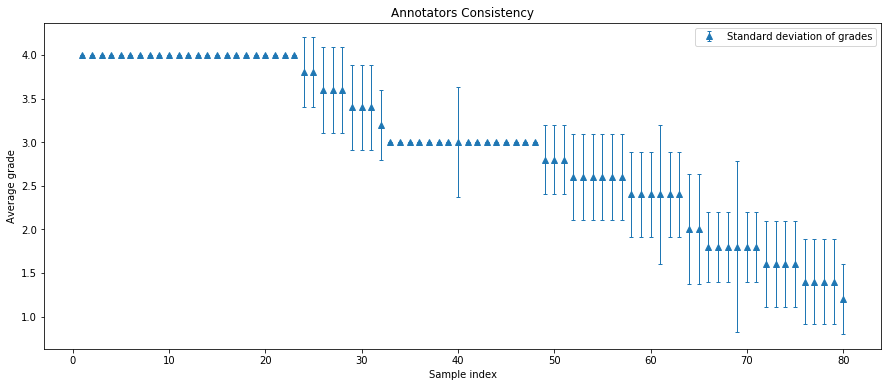

In [66]:
import matplotlib.pyplot as plt

# loading model data
X, y_binary, y_multiclass = mast.data, mast.target_binary, mast.target_multiclass

y_multiclass = sorted(y_multiclass, key=lambda i: (float(i[0])), reverse=True)
x = np.arange(1, len(mast.target_multiclass) + 1) # for plotting purposes

binary_target = [y_multiclass[i][0] for i in range(len(y_multiclass))]
stdev = np.array([y_multiclass[i][1] for i in range(len(y_multiclass))])

non_zero_stdevs = [x for x in stdev if x > 0]
print("################ Consistency of Annotations ################")
print()
print("Average of standard deviations:", sum(non_zero_stdevs)/len(non_zero_stdevs))
print("Max standard deviation:", max(non_zero_stdevs))
print("Performances with no standard deviation:", len(stdev) - np.count_nonzero(stdev))
print()

plt.figure(figsize=(15,6))
plt.title("Annotators Consistency")
plt.ylabel("Average grade")
plt.xlabel("Sample index")
error_bar = plt.errorbar(x, binary_target, stdev, marker='^', capsize=2, elinewidth=1, markeredgewidth=1,label="Standard deviation of grades", ls='none')
plt.legend()

plt.show()

In order to allow for the creation of Machine Learning models and measurement of their respectives performances, we import the necessary modules and create a learning curve plotting function.

In [67]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs)  
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

The first model to be evaluated is a Logistic Regression classifier used to predict fail/pass judgments. The classifier is trained with the the binary target and is executed multiple times with different training set configurations using a 5-fold cross validation. The learning curve for such model is then presented. Maximum accuracy obtained is 0.76.

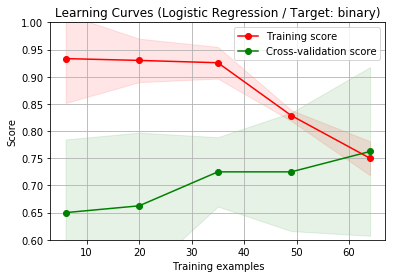

In [68]:
# setting up a 5-fold cross validation for estimators
cv = KFold(n_splits=5, shuffle=True, random_state=0)
title = r"Learning Curves (Logistic Regression / Target: binary)"

LOGIT_REG_ESTIMATOR = LogisticRegression()

# fitting the Logistic Regression classifier for further use
LOGIT_REG_ESTIMATOR.fit(X, y_binary)

plot_learning_curve(LOGIT_REG_ESTIMATOR, title, X, y_binary, (.6, 1), cv=cv)

plt.show()

Finally, our second model presents us a Linear Regression estimator for fractional grades. After training the model using the same aforementioned cross validation mechanism, we achieve the mean absolute errors listed below. Comparisons are made with dumb estimators.

In [76]:
LINEAR_REG_ESTIMATOR = LinearRegression()
LINEAR_REG_ESTIMATOR.fit(X, mast.target_multiclass[:,0])

# filling dumb model predictions which assigns random values to all performances to be estimated
base_random_grades = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]

mean_absolute_errors_random = []
mean_absolute_errors_only_twos = []
mean_absolute_errors_only_threes = []

for train_index, test_index in cv.split(X):
    y_test = mast.target_multiclass[:,0][test_index]
    
    np.random.shuffle(base_random_grades)
    mean_absolute_errors_random.append(mean_absolute_error(y_test, base_random_grades)) 
    
    predictions_all_two = np.repeat(2, len(y_test))
    mean_absolute_errors_only_twos.append(mean_absolute_error(y_test, predictions_all_two))
    
    predictions_all_three = np.repeat(3, len(y_test))    
    mean_absolute_errors_only_threes.append(mean_absolute_error(y_test, predictions_all_three)) 

# fitting the Logistic Regression classifier for further use
LINEAR_REG_ESTIMATOR.fit(X, mast.target_multiclass[:,0])

# running cross validation over our dataset
cross_val_errors = cross_val_score(LINEAR_REG_ESTIMATOR, X, mast.target_multiclass[:,0], scoring='neg_mean_absolute_error', cv=cv)

print("################ Linear Regression Model for grade estimation ################")
print()
print("Mean absolute error: Dumb Estimator (Only Grades 2) ->", sum(mean_absolute_errors_only_twos)/len(mean_absolute_errors_only_twos))
print("Mean absolute error: Dumb Estimator (Only Grades 3) ->", sum(mean_absolute_errors_only_threes)/len(mean_absolute_errors_only_threes))
print("Mean absolute error: Dumb Estimator (Random Grades) ->", sum(mean_absolute_errors_random)/len(mean_absolute_errors_random))
print("Mean absolute error: MAST Estimator (5-fold cross validation) ->", abs(sum(cross_val_errors)/len(cross_val_errors)))

################ Linear Regression Model for grade estimation ################

Mean absolute error: Dumb Estimator (Only Grades 2) -> 1.1275
Mean absolute error: Dumb Estimator (Only Grades 3) -> 0.7175
Mean absolute error: Dumb Estimator (Random Grades) -> 1.2325
Mean absolute error: MAST Estimator (5-fold cross validation) -> 0.598837845546


And that's it! Now, both of our models are ready to predict classifications and grades for new performances. 

Let's see how it works for new data left to be graded. First, we need to import a few processing functions from the previous notebook:

In [77]:
from essentia.standard import *
from essentia import Pool, array

DATA_FOLDER = "../data/"

# audio loading parameters
SAMPLE_RATE = 44100
WINDOW_SIZE = 1024
HOP_SIZE = 512
WINDOWING_METHOD = 'hann'

# onset detection parameters
ONSET_DETECTION_METHOD = 'hfc'

# used for quantizing purposes
ONSET_N_OF_BINS = 60

def _load_file_as_monophonic_waveform(file_path):
    fs = SAMPLE_RATE

    x = MonoLoader(filename = file_path, sampleRate = fs)()
    return x/np.max(np.abs(x))

def _extract_onset_vectors(waveform):
    od_hfc = OnsetDetection(method=ONSET_DETECTION_METHOD)
    w = Windowing(type = WINDOWING_METHOD)
    fft = FFT()
    c2p = CartesianToPolar()
    onsets = Onsets()

    pool = Pool()
    for frame in FrameGenerator(waveform, frameSize = WINDOW_SIZE, hopSize = HOP_SIZE):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features', od_hfc(mag, phase))

    onsets = onsets(array([pool['features']]),[1])
    return onsets

def make_bins(onset_times, window_size):
    bins = []
        
    for i in range(int(ONSET_N_OF_BINS)):
        for onset_time in onset_times:
            if i == ONSET_N_OF_BINS-1:
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + float('inf')):
                    bins.append(1)
                    break
                else:
                    continue
            else:                
                if window_size*(i - 0.5) <= onset_time <= window_size*(i + 0.5):
                    bins.append(1)
                    break
        else:
            bins.append(0)

    return bins

def adjust_onset_by_rate(onset, time_rescaling_factor):
    return onset - (onset * time_rescaling_factor)

This is the reference to be performed...

In [78]:
import IPython

reference_file = os.path.join(DATA_FOLDER, "Only References", "51_rhy2_ref126659.wav")

IPython.display.Audio(reference_file)

... and this is my recorded performance:

In [79]:
performance_file = os.path.join(DATA_FOLDER, "Only Performances", "test_for_prediction.wav")

IPython.display.Audio(performance_file)

The models estimate the grades and classifications given the distances between onset bins vectors. In order to obtain these distances we have to pre-process the onset times for references and performances as we did in the pre-processing notebook

In [80]:
def estimate_evaluation(performance_file, reference_file):
    # extract pure onset times
    onsets_performance = _extract_onset_vectors(_load_file_as_monophonic_waveform(performance_file))
    onsets_reference = _extract_onset_vectors(_load_file_as_monophonic_waveform(reference_file))

    # setting onset boundaries from first to last onsets
    onsets_performance = [ x - onsets_performance[0] for x in onsets_performance ]                   
    onsets_reference = [ x - onsets_reference[0] for x in onsets_reference  ]

    # re-scaling performance to match reference tempo
    perf_inner_duration = onsets_performance[-1] - onsets_performance[0]
    ref_inner_duration = onsets_reference[-1] - onsets_reference[0]   

    time_rescaling_factor = ((perf_inner_duration - ref_inner_duration) / perf_inner_duration)

    onsets_performance = [adjust_onset_by_rate(onset, time_rescaling_factor) for onset in onsets_performance]

    # onset window size is defined as a function of the audio duration
    window_size = ref_inner_duration / ONSET_N_OF_BINS

    perf_bins = make_bins(onsets_performance, window_size)
    ref_bins = make_bins(onsets_reference, window_size)

    # now we can calculate the distances,
    distances = [distance_function(perf_bins, ref_bins) for distance_function in DISTANCE_FUNCTIONS]
    
    return LOGIT_REG_ESTIMATOR.predict([distances])[0], LINEAR_REG_ESTIMATOR.predict([distances])[0]

print(estimate_evaluation(performance_file, reference_file))

(1, 3.3341160253713014)


Cool! My performance was accepted with a estimated grade of 3.33!

Finally, let's see how the trained models perform when tested against the whole MAST rhythmic dataset. The following will iterate over the dataset and run the estimators using each _(reference, performance)_ pair as input. The resulting prediction is then compared with the labeled information (pass/fail) present in the file name to check how well our predictions match the master's judgments.

In [83]:
import re
import random

files = os.path.join(DATA_FOLDER, 'rhy_m4a', 'm4a')

PATTERN = "(\d*)_rhy(\d*)_per(\d*)_(pass|fail).m4a"
PATTERN_REF = "(\d*)_rhy(\d*)_ref(\d*).m4a"

def get_reference_for_performance(question_set, question_number, reference_id):
    matched_reference = '%s_rhy%s_ref%s.m4a' % (question_set, question_number, reference_id)
    
    if os.path.isfile(os.path.join(files, matched_reference)):
        return matched_reference
    else:
        # get random reference
        all_refs = []
        for dirpath, dnames, fnames in os.walk(files):
            all_refs += [ref for ref in fnames if re.match(PATTERN_REF, ref)]
            
        candidates = []        
        for file in all_refs:
            search_groups = re.search(PATTERN_REF, file)
            question_set_ref = search_groups.group(1)
            question_number_ref = search_groups.group(2)
            
            if question_set == question_set_ref and question_number == question_number_ref:
                candidates.append(file)
                
        return random.sample(candidates,1)[0]    
    
    return None
            

all_files = []
for dirpath, dnames, fnames in os.walk(files):
    all_files += [perf for perf in fnames if re.match(PATTERN, perf)]
    

correct_predictions_logistic = 0
correct_predictions_linear = 0
all_predictions = 0

for performance in all_files:
    search_groups = re.search(PATTERN, performance)
    question_set = search_groups.group(1)
    question_number = search_groups.group(2)
    reference_id = search_groups.group(3)
    
    reference = get_reference_for_performance(question_set, question_number, reference_id)
    
    label = 'Accepted' if 'pass' in performance else 'Rejected'
    
    prediction = estimate_evaluation(os.path.join(DATA_FOLDER, 'rhy_m4a', 'm4a', performance), os.path.join(DATA_FOLDER, 'rhy_m4a', 'm4a', reference))
    
    if label == 'Accepted':
        if prediction[0] == 1:
            correct_predictions_logistic += 1
        if prediction[1] >= 3:
            correct_predictions_linear += 1
    elif label == 'Rejected':
        if prediction[0] == 0:
            correct_predictions_logistic += 1
        if prediction[1] < 3:
            correct_predictions_linear += 1
    
    all_predictions += 1

print('Accuracy of logistic model (correct_predictions, all_predictions): %i/%i' % (correct_predictions_logistic, all_predictions))
print('Accuracy of linear model (correct_predictions, all_predictions): %i/%i' % (correct_predictions_linear, all_predictions))

Accuracy of logistic model (correct_predictions, all_predictions): 687/1040
Accuracy of linear model (correct_predictions, all_predictions): 726/1040
